

> Outline for code: preprocessing, vector embedding, avg of vectors , for EAD used cosine similarity,tokenization, dimension reduction PCA, for conventional ML used LR and Random forest with embedding cbow for method 2 used CNN both cbow and sg embedding, used vader and texblob, analysed false positive and false negative for models and print 1st 5 false negatives and positives and 20 most common words captured in all the false positives and negatives. I think much more need to be done. Tried small dataset(5%) only to check the working of the code, have to check on full dataset.



In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
# dataset_path = 'Beauty_5.json'
dataset_path = '/content/Beauty_5.json'
df = pd.read_json(dataset_path, lines=True)

# Initial exploration to understand the dataset structure
print(df.head())

csv_file_path = 'Beauty_5.csv'  # Define the path for the output CSV file
df.to_csv(csv_file_path, index=False)  # Save the DataFrame to a CSV file without the index

# df = df.sample(frac=0.7, random_state=1)

print(df.info())


       reviewerID        asin reviewerName helpful  \
0  A1YJEY40YUW4SE  7806397051       Andrea  [3, 4]   
1   A60XNB876KYML  7806397051   Jessica H.  [1, 1]   
2  A3G6XNM240RMWA  7806397051        Karen  [0, 1]   
3  A1PQFP6SAJ6D80  7806397051        Norah  [2, 2]   
4  A38FVHZTNQ271F  7806397051    Nova Amor  [0, 0]   

                                          reviewText  overall  \
0  Very oily and creamy. Not at all what I expect...        1   
1  This palette was a decent price and I was look...        3   
2  The texture of this concealer pallet is fantas...        4   
3  I really can't tell what exactly this thing is...        2   
4  It was a little smaller than I expected, but t...        3   

                  summary  unixReviewTime   reviewTime  
0  Don't waste your money      1391040000  01 30, 2014  
1             OK Palette!      1397779200  04 18, 2014  
2           great quality      1378425600   09 6, 2013  
3  Do not work on my face      1386460800   12 8, 2013  

## Preprocessing

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    """
    Function to clean text data by removing special characters, stopwords,
    applying lowercasing, and other necessary tasks.
    """
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Lowercase the text
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [word for word in tokens if word not in stopwords.words('english')]
    # Join the words back into one string
    text = ' '.join(filtered_words)
    return text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preprocess and clean the review texts
df['cleaned_reviewText'] = df['reviewText'].apply(clean_text)

# At this point, you can save the cleaned data for further analysis
# For example: df.to_csv('cleaned_reviews.csv', index=False)

# Display the cleaned text for verification
print(df[['reviewText', 'cleaned_reviewText']].head())


                                          reviewText  \
0  Very oily and creamy. Not at all what I expect...   
1  This palette was a decent price and I was look...   
2  The texture of this concealer pallet is fantas...   
3  I really can't tell what exactly this thing is...   
4  It was a little smaller than I expected, but t...   

                                  cleaned_reviewText  
0  oily creamy expected ordered try highlight con...  
1  palette decent price looking different shades ...  
2  texture concealer pallet fantastic great cover...  
3  really tell exactly thing powder kind oil ish ...  
4  little smaller expected okay lasted long time ...  


In [ ]:
pip install gensim


## Word vectorization

In [ ]:
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize

# Tokenize the cleaned review texts
tokenized_reviews = [word_tokenize(review) for review in df['cleaned_reviewText']]

# Create Word2Vec embeddings
w2v_model_cbow = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, sg=0)  # CBOW
w2v_model_sg = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, sg=1)   # Skip-Gram

# Create FastText embeddings
fasttext_model = FastText(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, sg=1)  # Example with Skip-Gram


In [ ]:
import numpy as np

def average_vector(words, model):
#     return np.mean([model.wv[word] for word in words if word in model.wv], axis=0)
    """
    Calculate the average vector for a list of words using the specified model.

    Args:
    - words: List of words to be averaged.
    - model: Word2Vec or FastText model used to get vectors.
    - vector_size: Dimension of the vectors used by the model.

    Returns:
    - Averaged vector as a numpy array.
    """
    vector_list = [model.wv[word] for word in words if word in model.wv]

    if not vector_list:  # Check if the list is empty
        return np.zeros(vector_size)  # Return a zero vector if no words are found in the model's vocabulary
    else:
        return np.mean(vector_list, axis=0)

vector_size = 100

# Compute average vectors for each model
df['w2v_cbow_avg_vector'] = [average_vector(review, w2v_model_cbow) for review in tokenized_reviews]
df['w2v_sg_avg_vector'] = [average_vector(review, w2v_model_sg) for review in tokenized_reviews]
df['fasttext_avg_vector'] = [average_vector(review, fasttext_model) for review in tokenized_reviews]


## Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# Convert lists of vectors to a NumPy matrix for each model
w2v_cbow_matrix = np.array(df['w2v_cbow_avg_vector'].tolist())
w2v_sg_matrix = np.array(df['w2v_sg_avg_vector'].tolist())
fasttext_matrix = np.array(df['fasttext_avg_vector'].tolist())

# Calculate cosine similarity between the average vectors of CBOW and Skip-Gram models
cosine_sim_cbow_sg = cosine_similarity(w2v_cbow_matrix, w2v_sg_matrix)

# Calculate cosine similarity between the average vectors of CBOW and FastText models
cosine_sim_cbow_fasttext = cosine_similarity(w2v_cbow_matrix, fasttext_matrix)

# Calculate cosine similarity between the average vectors of Skip-Gram and FastText models
cosine_sim_sg_fasttext = cosine_similarity(w2v_sg_matrix, fasttext_matrix)

# Since cosine_similarity returns a matrix, you can take the average to get a single similarity measure
# between the entire sets of vectors for each model comparison
avg_sim_cbow_sg = np.mean(cosine_sim_cbow_sg)
avg_sim_cbow_fasttext = np.mean(cosine_sim_cbow_fasttext)
avg_sim_sg_fasttext = np.mean(cosine_sim_sg_fasttext)

print(f"Average Cosine Similarity between Word2Vec CBOW and Skip-Gram: {avg_sim_cbow_sg}")
print(f"Average Cosine Similarity between Word2Vec CBOW and FastText: {avg_sim_cbow_fasttext}")
print(f"Average Cosine Similarity between Word2Vec Skip-Gram and FastText: {avg_sim_sg_fasttext}")


In [ ]:
import pandas as pd


# Remove entries with a rating of 3 as they are considered neutral
df = df[df['overall'] != 3]

# Convert ratings into binary sentiment (1&2 = Negative, 4&5 = Positive)
df['sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)


print(df.info())

NameError: name 'df' is not defined

## LR using embedding cbow

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np


# Split df into training and testing sets before feature extraction
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = np.array(df_train['w2v_cbow_avg_vector'].tolist())
y_train = df_train['sentiment'].values
X_test = np.array(df_test['w2v_cbow_avg_vector'].tolist())
y_test = df_test['sentiment'].values

# X = np.array(df['w2v_cbow_avg_vector'].tolist())

# Print the shape of X
print("Shape of X_train:", X_train.shape)

# Print the shape of X
print("Shape of X_test:", X_test.shape)

# The number of features is the second element of the shape tuple
num_features = X_train.shape[1]
print("Number of features:", num_features)

# The number of features is the second element of the shape tuple
num_features = X_test.shape[1]
print("Number of features:", num_features)

Shape of X_train: (7054, 100)
Shape of X_test: (1764, 100)
Number of features: 100
Number of features: 100


## Dimension Reduction

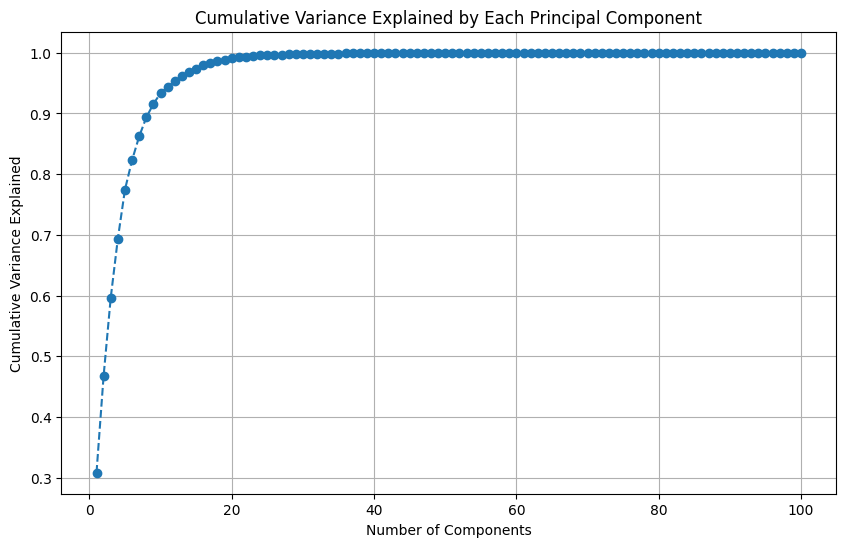

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Correct the n_components according to your dataset's actual size
# Example: Reducing to 50 components, or you might choose a number that's appropriate for your dataset
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X_train)

# Calculate the cumulative sum of explained variances
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the cumulative variance explained by the components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by Each Principal Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

In [ ]:
# # Step 2: Apply PCA for dimensionality reduction (optional)
# pca = PCA(n_components=20)  # Adjust n_components based on your requirement
# X_reduced = pca.fit_transform(X)

pca = PCA(n_components=10)  # Adjust n_components based on your requirement
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [ ]:
### Step 3: Train-Test Split
# y = df['sentiment'].values
# # X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)


# ### Step 4: Logistic Regression
# model = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
# model.fit(X_train, y_train)

# # Predict on the test set
# predictions = model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, predictions)
# print(f"Accuracy of Logistic Regression on reduced dimensions: {accuracy}")

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_reduced, y_train)

# Predict on the test set
predictions = model.predict(X_test_reduced)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of Logistic Regression on reduced dimensions: {accuracy}")

# Add predictions to df_test for error analysis
df_test['predictions'] = predictions


Accuracy of Logistic Regression on reduced dimensions: 0.8803854875283447


## Error Analysis LR

In [ ]:
# Assuming 'predictions' contains your model's predictions for X_test
# df_test['predictions'] = predictions

# Now, you can directly use df_test to analyze errors
fp_reviews = df_test[(df_test['predictions'] != df_test['sentiment']) & (df_test['predictions'] == 1)]['cleaned_reviewText']
fn_reviews = df_test[(df_test['predictions'] != df_test['sentiment']) & (df_test['predictions'] == 0)]['cleaned_reviewText']


In [ ]:
from collections import Counter

# Print some examples of false positive reviews
print("Some false positive reviews:")
for i, review in enumerate(fp_reviews[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false positives
fp_word_counts = Counter(" ".join(fp_reviews).split())
print("Common words in false positives:")
print(fp_word_counts.most_common(20))  # Printing top 20 common words

# Print some examples of false negative reviews
print("\nSome false negative reviews:")
for i, review in enumerate(fn_reviews[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false negatives
fn_word_counts = Counter(" ".join(fn_reviews).split())
print("Common words in false negatives:")
print(fn_word_counts.most_common(20))  # Printing top 20 common words


Some false positive reviews:
1: sucked right sheer color like white though nd nail guides came wasted _

2: tried reading reviews say helped reducing amount shedding sure helped growth think using made scalp itch bad itching terrible going stick know continue use coconut oil instead

3: using back year awesome results changed formulation breaks

4: buy ton stuff amazon reviews important purchasing decisions bought pair cuticle nippers really high reviews stating things like clippers made germany high quality got adequately satisfied seemed job sharp precise breeze handle hey get pay nip well last night using nip awkward part toenail normally difficult reach regular nail clipper say thinnest toenails also say hard thick toenails one regular squeeze nippers without real perceived force end nippers break half stab hand broken edge feel like solid piece metal snapping like bend crack flexible plaster center something sort investigated broken edges found filled black porous material obvious

## End of embedding LR

## Random forest using Embedding Cbow

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X_reduced and y have already been defined
# X_reduced is your feature matrix after dimensionality reduction (or you could use X directly)
# y is your array of labels

# # Split the data into training and testing sets
# y = df['sentiment'].values
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed

# Train the model
# random_forest_model.fit(X_train, y_train)
random_forest_model.fit(X_train_reduced, y_train)


# Predict on the test set
# predictions_rf = random_forest_model.predict(X_test)
predictions_rf = random_forest_model.predict(X_test_reduced)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, predictions_rf)
print(f"Accuracy of Random Forest: {accuracy_rf}")


Accuracy of Random Forest: 0.8837868480725624


## Error Analysis Random Forest

In [ ]:
# Assuming 'predictions' contains your model's predictions for X_test
df_test['predictions_rf'] = predictions_rf

# Now, you can directly use df_test to analyze errors
fp_reviews_rf = df_test[(df_test['predictions_rf'] != df_test['sentiment']) & (df_test['predictions_rf'] == 1)]['cleaned_reviewText']
fn_reviews_rf = df_test[(df_test['predictions_rf'] != df_test['sentiment']) & (df_test['predictions_rf'] == 0)]['cleaned_reviewText']


In [ ]:
# Print some examples of false positive reviews
print("Some false positive reviews:")
for i, review in enumerate(fp_reviews_rf[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false positives
fp_word_counts = Counter(" ".join(fp_reviews_rf).split())
print("Common words in false positives:")
print(fp_word_counts.most_common(20))  # Printing top 20 common words

# Print some examples of false negative reviews
print("\nSome false negative reviews:")
for i, review in enumerate(fn_reviews_rf[:5], start=1):  # Adjust the slice as needed
    print(f"{i}: {review}\n")

# Exploring common words in false negatives
fn_word_counts = Counter(" ".join(fn_reviews_rf).split())
print("Common words in false negatives:")
print(fn_word_counts.most_common(20))  # Printing top 20 common words


Some false positive reviews:
1: used product consistenly completely gone waiting miracle reviewers said anything skin one way dried skin little expected nothing clear acne minimize fine lines texture worth money like beauty products

2: sucked right sheer color like white though nd nail guides came wasted _

3: tried reading reviews say helped reducing amount shedding sure helped growth think using made scalp itch bad itching terrible going stick know continue use coconut oil instead

4: using back year awesome results changed formulation breaks

5: buy ton stuff amazon reviews important purchasing decisions bought pair cuticle nippers really high reviews stating things like clippers made germany high quality got adequately satisfied seemed job sharp precise breeze handle hey get pay nip well last night using nip awkward part toenail normally difficult reach regular nail clipper say thinnest toenails also say hard thick toenails one regular squeeze nippers without real perceived force 

## End of Random forest embedding

## LR Tf-idf

## end of Lr tf-idf

In [ ]:
# Convert ratings into binary sentiment (Positive: 1, Negative: 0)
df['sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else None))
df.dropna(subset=['sentiment'], inplace=True)  # Remove any rows with neutral ratings (3)
df['sentiment'] = df['sentiment'].astype(int)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8818 entries, 1298 to 90561
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   reviewerID           8818 non-null   object
 1   asin                 8818 non-null   object
 2   reviewerName         8750 non-null   object
 3   helpful              8818 non-null   object
 4   reviewText           8818 non-null   object
 5   overall              8818 non-null   int64 
 6   summary              8818 non-null   object
 7   unixReviewTime       8818 non-null   int64 
 8   reviewTime           8818 non-null   object
 9   cleaned_reviewText   8818 non-null   object
 10  w2v_cbow_avg_vector  8818 non-null   object
 11  w2v_sg_avg_vector    8818 non-null   object
 12  fasttext_avg_vector  8818 non-null   object
 13  sentiment            8818 non-null   int64 
dtypes: int64(3), object(11)
memory usage: 1.0+ MB
None


## CNN

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec, FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenized_reviews = [word_tokenize(review) for review in df['cleaned_reviewText']]
tokenizer.fit_on_texts(df['cleaned_reviewText'])
word_index = tokenizer.word_index
total_vocabulary_size = len(word_index)

print(f'Total vocabulary size: {total_vocabulary_size}')

Total vocabulary size: 17073


In [ ]:
sequences = tokenizer.texts_to_sequences(df['cleaned_reviewText'])
sequence_lengths = [len(sequence) for sequence in sequences]

# Analyze the distribution of sequence lengths
print(f'Maximum sequence length: {max(sequence_lengths)}')
print(f'Mean sequence length: {np.mean(sequence_lengths)}')
print(f'Median sequence length: {np.median(sequence_lengths)}')

# You can also use percentile to determine a more flexible maxlen
percentile_length = np.percentile(sequence_lengths, 95)  # For example, the 95th percentile
print(f'95th percentile of sequence length: {percentile_length}')

Maximum sequence length: 659
Mean sequence length: 43.000340213200275
Median sequence length: 28.0
95th percentile of sequence length: 125.0


## CNN cbow

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

embedding_dim = 100  # The dimensionality of your Word2Vec/FastText embeddings
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model_cbow.wv:  # Check if the word is in the model's vocabulary
        embedding_vector = w2v_model_cbow.wv[word]  # Correct way to access the vector
        embedding_matrix[i] = embedding_vector

maxlen = 125  # Maximum length of all sequences
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# sequences = pad_sequences(tokenized_reviews, maxlen=maxlen)
y = df['sentiment'].values

# Split data while retaining indices
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
#     sequences, y, range(len(y)), test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split( X, y, range(len(y)), test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary to see the architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 125, 100)          1707400   
                                                                 
 conv1d (Conv1D)             (None, 121, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1771657 (6.76 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 1707400 (6.51 MB)
_________________________________________________________________


In [ ]:
# Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=2)

model.fit(X_train, y_train, epochs=10, batch_size=32)


# Evaluate the model on the test data
# ann_loss, ann_accuracy = ann_model.evaluate(X_test.toarray(), y_test_one_hot)
cnn_loss, cnn_accuracy_cbow = model.evaluate(X_test, y_test)
print("CNN Accuracy:", cnn_accuracy_cbow)

Epoch 1/10
221/221 [==============================] - 8s 32ms/step - loss: 0.3367 - accuracy: 0.8724
Epoch 2/10
221/221 [==============================] - 8s 36ms/step - loss: 0.2878 - accuracy: 0.8845
Epoch 3/10
221/221 [==============================] - 6s 25ms/step - loss: 0.2642 - accuracy: 0.8925
Epoch 4/10
221/221 [==============================] - 7s 30ms/step - loss: 0.2343 - accuracy: 0.9032
Epoch 5/10
221/221 [==============================] - 7s 30ms/step - loss: 0.2228 - accuracy: 0.9050
Epoch 6/10
221/221 [==============================] - 6s 25ms/step - loss: 0.1966 - accuracy: 0.9239
Epoch 7/10
221/221 [==============================] - 8s 35ms/step - loss: 0.1680 - accuracy: 0.9339
Epoch 8/10
221/221 [==============================] - 6s 25ms/step - loss: 0.1501 - accuracy: 0.9430
Epoch 9/10
221/221 [==============================] - 8s 36ms/step - loss: 0.1327 - accuracy: 0.9508
Epoch 10/10
56/56 [==============================] - 1s 11ms/step - loss: 0.3151 - accuracy

## Error Analysis CNN cbow

In [ ]:
# Predict on the test set
# predictions_proba = model.predict(X_test)
# predictions_cbow = (predictions_proba > 0.5).astype("int32")

# Create a new df_test that corresponds to X_test
df_test_cnn = df.iloc[indices_test].reset_index(drop=True)

# Assuming you've already made predictions with your CNN
predictions_proba = model.predict(X_test)
predictions_cnn = (predictions_proba > 0.5).astype("int32").flatten()

# Add predictions to df_test_cnn
df_test_cnn['predictions'] = predictions_cnn


56/56 [==============================] - 1s 12ms/step


In [ ]:
from collections import Counter

# Identify false positives and false negatives
fp_reviews_cnn = df_test_cnn[(df_test_cnn['predictions'] == 1) & (df_test_cnn['sentiment'] == 0)]['cleaned_reviewText']
fn_reviews_cnn = df_test_cnn[(df_test_cnn['predictions'] == 0) & (df_test_cnn['sentiment'] == 1)]['cleaned_reviewText']

# Print some examples and analyze common words
print("Some false positive reviews (CNN):")
print(fp_reviews_cnn.head().to_string(index=False), "\n")

print("Some false negative reviews (CNN):")
print(fn_reviews_cnn.head().to_string(index=False), "\n")

# Common words in false positives
fp_word_counts_cnn = Counter(" ".join(fp_reviews_cnn).split())
print("Common words in false positives (CNN):")
print(fp_word_counts_cnn.most_common(20))

# Common words in false negatives
fn_word_counts_cnn = Counter(" ".join(fn_reviews_cnn).split())
print("Common words in false negatives (CNN):")
print(fn_word_counts_cnn.most_common(20))


Some false positive reviews (CNN):
sucked right sheer color like white though nd n...
using back year awesome results changed formula...
buy ton stuff amazon reviews important purchasi...
joke small plastic flimsy price really cheep gu...
surprised great responses people product defini... 

Some false negative reviews (CNN):
years old couple years ago started get fine lin...
really like dryer hands could fit although quie...
practical product mainly look one thing suppose...
read excellent reviews product sephora com boug...
losing lot hair dermatologist suggested shampoo... 

Common words in false positives (CNN):
[('product', 114), ('hair', 105), ('like', 89), ('one', 58), ('skin', 55), ('would', 54), ('really', 53), ('use', 50), ('used', 44), ('get', 43), ('good', 40), ('using', 34), ('even', 34), ('smell', 33), ('products', 33), ('well', 30), ('great', 29), ('day', 28), ('better', 28), ('face', 28)]
Common words in false negatives (CNN):
[('hair', 64), ('like', 29), ('one', 19), ('

## CNN Sg

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

embedding_dim = 100  # The dimensionality of your Word2Vec/FastText embeddings
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model_sg.wv:  # Check if the word is in the model's vocabulary
        embedding_vector = w2v_model_sg.wv[word]  # Correct way to access the vector
        embedding_matrix[i] = embedding_vector

maxlen = 125  # Maximum length of all sequences
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# sequences = pad_sequences(tokenized_reviews, maxlen=maxlen)
y = df['sentiment'].values

# Split data while retaining indices
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
#     sequences, y, range(len(y)), test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split( X, y, range(len(y)), test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary to see the architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 125, 100)          1707400   
                                                                 
 conv1d_1 (Conv1D)           (None, 121, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1771657 (6.76 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 1707400 (6.51 MB)
_________________________________________________________________


In [ ]:
# Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), verbose=2)

model.fit(X_train, y_train, epochs=10, batch_size=32)


# Evaluate the model on the test data
# ann_loss, ann_accuracy = ann_model.evaluate(X_test.toarray(), y_test_one_hot)
cnn_loss, cnn_accuracy_sg = model.evaluate(X_test, y_test)
print("CNN Accuracy:", cnn_accuracy_sg)

Epoch 1/10
221/221 [==============================] - 7s 25ms/step - loss: 0.3267 - accuracy: 0.8774
Epoch 2/10
221/221 [==============================] - 8s 35ms/step - loss: 0.2550 - accuracy: 0.8978
Epoch 3/10
221/221 [==============================] - 5s 25ms/step - loss: 0.2208 - accuracy: 0.9083
Epoch 4/10
221/221 [==============================] - 7s 33ms/step - loss: 0.1847 - accuracy: 0.9246
Epoch 5/10
221/221 [==============================] - 6s 27ms/step - loss: 0.1595 - accuracy: 0.9383
Epoch 6/10
221/221 [==============================] - 6s 27ms/step - loss: 0.1252 - accuracy: 0.9585
Epoch 7/10
221/221 [==============================] - 7s 34ms/step - loss: 0.0976 - accuracy: 0.9742
Epoch 8/10
221/221 [==============================] - 6s 25ms/step - loss: 0.0766 - accuracy: 0.9826
Epoch 9/10
221/221 [==============================] - 8s 35ms/step - loss: 0.0587 - accuracy: 0.9891
Epoch 10/10
56/56 [==============================] - 1s 19ms/step - loss: 0.2759 - accuracy

## Error Analysis CNN Sg

In [ ]:
# # Predict on the test set
# predictions_proba = model.predict(X_test)
# predictions_cbow = (predictions_proba > 0.5).astype("int32")

# Predict on the test set
# predictions_proba = model.predict(X_test)
# predictions_cbow = (predictions_proba > 0.5).astype("int32")

# Create a new df_test that corresponds to X_test
df_test_cnn_sg = df.iloc[indices_test].reset_index(drop=True)

# Assuming you've already made predictions with your CNN
predictions_proba = model.predict(X_test)
predictions_cnn_sg = (predictions_proba > 0.5).astype("int32").flatten()

# Add predictions to df_test_cnn
df_test_cnn_sg['predictions'] = predictions_cnn_sg



56/56 [==============================] - 1s 24ms/step


In [ ]:
from collections import Counter

# Identify false positives and false negatives
fp_reviews_cnn_sg = df_test_cnn_sg[(df_test_cnn_sg['predictions'] == 1) & (df_test_cnn_sg['sentiment'] == 0)]['cleaned_reviewText']
fn_reviews_cnn_sg = df_test_cnn_sg[(df_test_cnn_sg['predictions'] == 0) & (df_test_cnn_sg['sentiment'] == 1)]['cleaned_reviewText']

# Print some examples and analyze common words
print("Some false positive reviews (CNN):")
print(fp_reviews_cnn_sg.head().to_string(index=False), "\n")

print("Some false negative reviews (CNN):")
print(fn_reviews_cnn_sg.head().to_string(index=False), "\n")

# Common words in false positives
fp_word_counts_cnn_sg = Counter(" ".join(fp_reviews_cnn_sg).split())
print("Common words in false positives (CNN):")
print(fp_word_counts_cnn_sg.most_common(20))

# Common words in false negatives
fn_word_counts_cnn_sg = Counter(" ".join(fn_reviews_cnn_sg).split())
print("Common words in false negatives (CNN):")
print(fn_word_counts_cnn_sg.most_common(20))


Some false positive reviews (CNN):
sucked right sheer color like white though nd n...
using back year awesome results changed formula...
buy ton stuff amazon reviews important purchasi...
joke small plastic flimsy price really cheep gu...
surprised great responses people product defini... 

Some false negative reviews (CNN):
skin oily would perfect due skin type elavonne ...
get little white hard specks chin around mouth ...
smells better feels better used wet dry hair st...
got polish looked purple bottle still beautiful...
always get suckered seen tv products never work... 

Common words in false positives (CNN):
[('product', 94), ('hair', 84), ('like', 73), ('really', 55), ('use', 46), ('one', 45), ('get', 41), ('would', 41), ('skin', 40), ('used', 36), ('using', 34), ('good', 32), ('products', 31), ('well', 30), ('great', 27), ('even', 27), ('shampoo', 27), ('better', 25), ('smell', 25), ('much', 25)]
Common words in false negatives (CNN):
[('like', 28), ('face', 23), ('hair', 17),

### VADER SA

In [ ]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure the VADER lexicon is downloaded
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER to analyze the sentiments of reviews
df['scores'] = df['cleaned_reviewText'].apply(lambda review: sid.polarity_scores(review))
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['vader_sentiment'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

# Display the dataframe to verify the results
df[['cleaned_reviewText', 'compound', 'vader_sentiment']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,cleaned_reviewText,compound,vader_sentiment
1298,wanted coppery orange color dyed black hair pi...,-0.6808,neg
23014,purchased item gift mom ran nail polish wished...,0.9293,pos
32981,really like product hair relaxed color treated...,0.9484,pos
186326,like taste vitamins leave mouth saw immediatel...,0.9686,pos
10876,know one brushes long theory clear need exfoli...,0.6705,pos


In [ ]:
# Convert 'vader_sentiment' from 'pos'/'neg' to 1/0 to match 'sentiment'
df['vader_sentiment_binary'] = df['vader_sentiment'].apply(lambda x: 1 if x == 'pos' else 0)
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy_vader = accuracy_score(df['sentiment'], df['vader_sentiment_binary'])

print(f"Accuracy of VADER sentiment analysis: {accuracy_vader}")


Accuracy of VADER sentiment analysis: 0.8813789975051032


## Error Analysis Vader

In [ ]:
# Identify false positives and false negatives
fp_vader = df[(df['vader_sentiment_binary'] == 1) & (df['sentiment'] == 0)]
fn_vader = df[(df['vader_sentiment_binary'] == 0) & (df['sentiment'] == 1)]


In [ ]:
from collections import Counter

# Print some examples of false positive reviews
print("Some false positive reviews (VADER):")
for i, text in enumerate(fp_vader['cleaned_reviewText'].head(5), 1):  # Adjust as needed
    print(f"{i}: {text}\n")

# Analyze common words in false positives
fp_vader_words = Counter(" ".join(fp_vader['cleaned_reviewText']).split())
print("Common words in false positives (VADER):")
print(fp_vader_words.most_common(20))  # Top 20 common words


# Print some examples of false negative reviews
print("Some false negative reviews (VADER):")
for i, text in enumerate(fn_vader['cleaned_reviewText'].head(5), 1):  # Adjust as needed
    print(f"{i}: {text}\n")

# Analyze common words in false negatives
fn_vader_words = Counter(" ".join(fn_vader['cleaned_reviewText']).split())
print("\nCommon words in false negatives (VADER):")
print(fn_vader_words.most_common(20))  # Top 20 common words


Some false positive reviews (VADER):
1: worked week scalp started scale maybe higher percentage coal tar would better

2: like rubbing coffee grounds face know people sensitive smell others got tremendous reviews like

3: like would pay make last long makes happy chick also told friend pay

4: used cover pimples great job like talc free product work make much difference lighten circles eyes great blemishes

5: olay regenerist line seems kind hit miss products work great others unfortunately one group used per instructions times week gone almost whole box noticed improvement puffiness eyes fine lines around eyes frankly see change applicator okay seems real gimmick says massage eye area help reduce puffiness contrary every thing read tells never tug pull delicate skin around eyes despite best attempts way massage product without tugging pulling skin dab forget massaging idea case noticed improvements purchasing product

Common words in false positives (VADER):
[('hair', 658), ('product'

## TEXTBLOB

In [ ]:
pip install textblob


In [ ]:
from textblob import TextBlob

# df['textblob_sentiment'] = df['cleaned_reviewText'].apply(lambda text: TextBlob(text).sentiment.polarity)
# df['textblob_sentiment_label'] = df['textblob_sentiment'].apply(lambda score: 'pos' if score >= 0 else 'neg')
# df[['cleaned_reviewText', 'textblob_sentiment', 'textblob_sentiment_label']]

df['textblob_sentiment'] = df['cleaned_reviewText'].apply(lambda text: TextBlob(text).sentiment.polarity)
df['textblob_subjectivity'] = df['cleaned_reviewText'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

# Label the sentiment as 'pos' or 'neg' based on the polarity
df['textblob_sentiment_label'] = df['textblob_sentiment'].apply(lambda score: 'pos' if score >= 0 else 'neg')

# Display the DataFrame with the new columns
df[['cleaned_reviewText', 'textblob_sentiment', 'textblob_sentiment_label', 'textblob_subjectivity']]


,cleaned_reviewText,textblob_sentiment,textblob_sentiment_label,textblob_subjectivity
1298,wanted coppery orange color dyed black hair pi...,-0.136111,neg,0.484722
23014,purchased item gift mom ran nail polish wished...,0.407273,pos,0.628687
32981,really like product hair relaxed color treated...,0.600000,pos,0.600000
186326,like taste vitamins leave mouth saw immediatel...,0.055833,pos,0.420556
10876,know one brushes long theory clear need exfoli...,0.169481,pos,0.445887
...,...,...,...,...
43659,really excited shampoo heard good reviews love...,0.362500,pos,0.598333
25068,bought cousin loved used happier,0.700000,pos,0.800000
182560,review beenigma bee venom cream misc wife usin...,0.043939,pos,0.371212
56718,use number olay products highly recommend pro ...,0.053333,pos,0.180000


In [ ]:
df['textblob_sentiment_binary'] = df['textblob_sentiment_label'].apply(lambda x: 1 if x == 'pos' else 0)
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy_textblob = accuracy_score(df['sentiment'], df['textblob_sentiment_binary'])

print(f"Accuracy of Textblob sentiment analysis: {accuracy_textblob}")

Accuracy of Textblob sentiment analysis: 0.8708323882966659


## Error Analysis Textblob

In [ ]:
from collections import Counter

# Identify false positives and false negatives
fp_textblob = df[(df['textblob_sentiment_binary'] == 1) & (df['sentiment'] == 0)]
fn_textblob = df[(df['textblob_sentiment_binary'] == 0) & (df['sentiment'] == 1)]

# Print examples of false positive reviews
print("Some false positive reviews (TextBlob):")
for i, text in enumerate(fp_textblob['cleaned_reviewText'].head(5), 1):  # Adjust the slice as needed
    print(f"{i}: {text}\n")

# Common words in false positives
fp_textblob_words = Counter(" ".join(fp_textblob['cleaned_reviewText']).split())
print("Common words in false positives (TextBlob):")
print(fp_textblob_words.most_common(20))  # Top 20 common words

# Print examples of false negative reviews
print("Some false negative reviews (TextBlob):")
for i, text in enumerate(fn_textblob['cleaned_reviewText'].head(5), 1):  # Adjust the slice as needed
    print(f"{i}: {text}\n")

# Common words in false negatives
fn_textblob_words = Counter(" ".join(fn_textblob['cleaned_reviewText']).split())
print("\nCommon words in false negatives (TextBlob):")
print(fn_textblob_words.most_common(20))  # Top 20 common words

Some false positive reviews (TextBlob):
1: worked week scalp started scale maybe higher percentage coal tar would better

2: like rubbing coffee grounds face know people sensitive smell others got tremendous reviews like

3: like would pay make last long makes happy chick also told friend pay

4: used cover pimples great job like talc free product work make much difference lighten circles eyes great blemishes

5: olay regenerist line seems kind hit miss products work great others unfortunately one group used per instructions times week gone almost whole box noticed improvement puffiness eyes fine lines around eyes frankly see change applicator okay seems real gimmick says massage eye area help reduce puffiness contrary every thing read tells never tug pull delicate skin around eyes despite best attempts way massage product without tugging pulling skin dab forget massaging idea case noticed improvements purchasing product

Common words in false positives (TextBlob):
[('hair', 610), ('pr

In [ ]:
# model_performances = {
# #     "Logistic Regression": accuracy_lr,
#     "CNN": cnn_accuracy,
#     "VADER": accuracy_vader,
#     "TextBlob": accuracy_textblob
# }
